In [1]:
from base_rl.train import ParallelTrainer, OnlineTrainer
from base_rl.callbacks import SaveBestPolicy, SavePolicyOnTrainingEnd
import matplotlib.pyplot as plt
from q_learning.algorithm import QLearningAlgo, QLPolicy
from envs.env_creator import env_creator, IBGymModelQ_creator
from base_rl.eval_policy import EvalDiscreteStatePolicy
from base_rl.scheduler import DecayingExpScheduler, LinearScheduler, DecayingExpContinuousScheduler
import random

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]
fixed_digits = 6
experiment_id = random.randrange(111111, 999999, fixed_digits)

In [3]:
device = 'cuda'
steps_per_episode = 1000
model_names = [  'model_aeq-new', 'model_final_h-new']

alpha


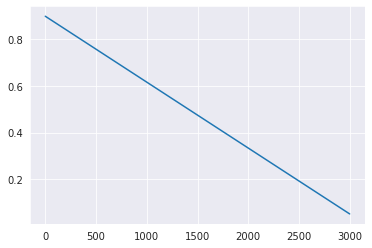

epsilon


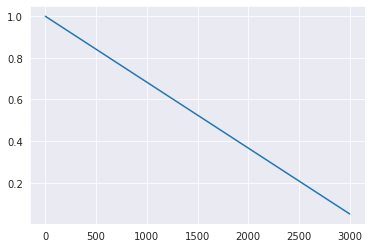

In [4]:
gamma = 0.995
total_epochs = 6000
print('alpha')
alpha = LinearScheduler(start=0.9, end=0.05, total_steps=3000)
print('epsilon')
epsilon = LinearScheduler(start=1, end=0.05, total_steps=3000)

In [5]:
best_save_paths = []
last_save_paths = []
models_env_kwargs = []
for model_name in model_names:
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device,
                  'model_path': f'tmp/state_quantization/{model_name}'}
    best_save_paths.append(f'tmp/q_learning/mb_q_policy_best_{model_name}_{experiment_id}.pkl')
    last_save_paths.append(f'tmp/q_learning/mb_q_policy_{model_name}_{experiment_id}.pkl')
    models_env_kwargs.append(env_kwargs)


## Train

In [ ]:


workers_kwargs = []
for i, model_name in enumerate(model_names):
    trainer_config = {
        'algo': QLearningAlgo(
            comment=f',id=mb_{experiment_id},model={model_name},gamma={gamma},total_epochs={total_epochs}',
            epochs=total_epochs, alpha=alpha, gamma=gamma, epsilon=epsilon, env_creator=IBGymModelQ_creator,
            env_kwargs=models_env_kwargs[i], reward_offset=2000, show_reward_type='mean'
        ),
        'callbacks': [
            SaveBestPolicy(save_path=best_save_paths[i]),
            SavePolicyOnTrainingEnd(save_path=last_save_paths[i])
        ]
    }
    workers_kwargs.append(trainer_config)

parallel_trainer = ParallelTrainer(trainer_class=OnlineTrainer, workers_kwargs=workers_kwargs)
parallel_trainer.train()

## Evaluate best saves

In [ ]:
evaluators = []
for i, model_name in enumerate(model_names):
    eval_policy = QLPolicy.load(best_save_paths[i])
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=models_env_kwargs[i])
    evaluator.evaluate(epochs=25)
    evaluators.append(evaluator)
for evaluator in evaluators:
    print(evaluator.env_kwargs['model_path'])
    print(f'Reward Mean: {evaluator.eval_mean}')
    print(f'Reward std : {evaluator.eval_std}')

In [ ]:
plt.plot(evaluators[-1].eval_trajectories[3]['actions'])

In [ ]:
from envs.plot import plot_industrial_benchmark_trajectories

plot_industrial_benchmark_trajectories(evaluators[-1].eval_trajectories[0]['info'])

## Evaluate last saves

In [ ]:
evaluators = []
for i, model_name in enumerate(model_names):
    eval_policy = QLPolicy.load(last_save_paths[i])
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=models_env_kwargs[i])
    evaluator.evaluate(epochs=25)
    evaluators.append(evaluator)
for evaluator in evaluators:
    print(evaluator.env_kwargs['model_path'])
    print(f'Reward Mean: {evaluator.eval_mean}')
    print(f'Reward std : {evaluator.eval_std}')